# K Nearest Neighbours

- Simply assigns a label to new data based on the distance between old data and new data.
- What points are this new point closest to?
- Always chose an odd K results in no tie or we can choose the nearest point (sklearn choses the nearest point if there is a tie)
- We want a K value that minimises error.
- We can use CV or grid search.
- Scaling is necessary for KNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../DATA/gene_expression.csv')

In [3]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


<AxesSubplot:xlabel='Gene One', ylabel='Gene Two'>

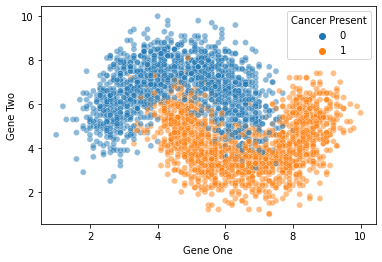

In [5]:
sns.scatterplot(data=df, x='Gene One', y='Gene Two', hue='Cancer Present', alpha=0.5)

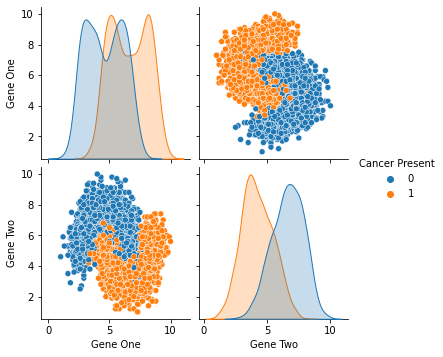

In [6]:
sns.pairplot(data=df, hue='Cancer Present')

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
X = df.drop('Cancer Present', axis=1)

In [9]:
y = df['Cancer Present']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=101)

In [17]:
scaler = StandardScaler()

In [18]:
scaled_X_train = scaler.fit_transform(X_train)

In [19]:
scaled_X_test = scaler.transform(X_test)

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [22]:
knn_model.fit(scaled_X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [24]:
y_pred = knn_model.predict(scaled_X_test)

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
confusion_matrix(y_test, y_pred)

array([[382,  41],
       [ 31, 446]], dtype=int64)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       423
           1       0.92      0.94      0.93       477

    accuracy                           0.92       900
   macro avg       0.92      0.92      0.92       900
weighted avg       0.92      0.92      0.92       900



# Choosing K

In [34]:
from sklearn.metrics import accuracy_score

# Elbow method
test_error_rates = []

for k in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train, y_train)
    
    y_pred_test = knn_model.predict(scaled_X_test)
    err = 1 - accuracy_score(y_test, y_pred_test)
    test_error_rates.append(err)
    

In [35]:
test_error_rates

[0.07999999999999996,
 0.0855555555555556,
 0.06666666666666665,
 0.06666666666666665,
 0.06777777777777783,
 0.06000000000000005,
 0.06555555555555559,
 0.061111111111111116,
 0.06555555555555559,
 0.06222222222222218,
 0.06666666666666665,
 0.06333333333333335,
 0.06555555555555559,
 0.06444444444444442,
 0.06666666666666665,
 0.061111111111111116,
 0.06000000000000005,
 0.061111111111111116,
 0.06222222222222218,
 0.06444444444444442,
 0.06222222222222218,
 0.06666666666666665,
 0.061111111111111116,
 0.05888888888888888,
 0.06222222222222218,
 0.06555555555555559,
 0.06222222222222218,
 0.06000000000000005,
 0.061111111111111116]

Text(0.5, 0, 'K Num')

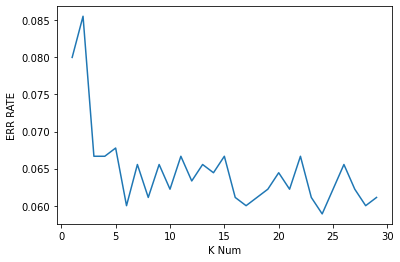

In [36]:
plt.plot(range(1, 30), test_error_rates)
plt.ylabel('ERR RATE')
plt.xlabel('K Num')

# Pipeline Setup

In [37]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

In [38]:
# Needs very specific string codes
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [39]:
# I want to scale then fit model
operations = [('scaler', scaler), ('knn', knn)]

In [40]:
from sklearn.pipeline import Pipeline

In [41]:
pipe = Pipeline(operations)

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
k_values = list(range(1, 20))
k_values

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [44]:
# Format = <step>__<param name>
param_grid = {
    'knn__n_neighbors': k_values
}

In [46]:
# Give pipeline to grid search.
full_cv_classifier = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [47]:
# Pipeline does the scale for us!!
full_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [49]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=19))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=19),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 19,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [50]:
# For the final model.
full_preds = full_cv_classifier.predict(X_test)

In [51]:
print(classification_report(y_test, full_preds))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       423
           1       0.93      0.95      0.94       477

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [52]:
new_pat = [[3.8, 6.4]]
full_cv_classifier.predict_proba(new_pat)

array([[0.78947368, 0.21052632]])